In [1]:
import os
import uproot
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import awkward as ak

def load_root_file(file_path, branches=None, print_branches=False):
    all_branches = {}
    with uproot.open(file_path) as file:
        tree = file["tree"]
        # Load all ROOT branches into array if not specified
        if branches is None:
            branches = tree.keys()
        # Option to print the branch names
        if print_branches:
            print("Branches:", tree.keys())
        # Each branch is added to the dictionary
        for branch in branches:
            try:
                all_branches[branch] = (tree[branch].array(library="np"))
            except uproot.KeyInFileError as e:
                print(f"KeyInFileError: {e}")
        # Number of events in file
        all_branches['event'] = tree.num_entries
    return all_branches

branches_list = [
    't5_innerRadius',
    't5_bridgeRadius',
    't5_outerRadius',
    't5_pt',
    't5_eta',
    't5_phi',
    't5_isFake',
    't5_t3_idx0',
    't5_t3_idx1',
    't5_pMatched'
]

# Hit-dependent branches
suffixes = ['r', 'z', 'eta', 'phi', 'layer']
branches_list += [f't5_t3_{i}_{suffix}' for i in [0, 2, 4] for suffix in suffixes]

file_path = "1000_no_radii_new.root"
branches = load_root_file(file_path, branches_list)

/tmp/ipykernel_1334090/2923945446.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
z_max = np.max([np.max(event) for event in branches[f't5_t3_4_z']])
r_max = np.max([np.max(event) for event in branches[f't5_t3_4_r']])
eta_max = 2.5

print(f'Z max: {z_max}, R max: {r_max}, Eta max: {eta_max}')

Z max: 267.2349853515625, R max: 110.10993957519531, Eta max: 2.5


In [3]:
features_list = []

for event in range(branches['event']):
    # Determine the number of elements in this event
    num_elements = len(branches['t5_t3_idx0'][event])

    for i in range(num_elements):
        features_iter = []
        
        idx0 = branches['t5_t3_idx0'][event][i]
        idx1 = branches['t5_t3_idx1'][event][i]

        # Collect features using idx0
        features_iter.extend([
            np.abs(branches['t5_t3_0_eta'][event][idx0]) / eta_max,
            np.abs(branches['t5_t3_0_z'][event][idx0]) / z_max,
            branches['t5_t3_0_r'][event][idx0] / r_max,
            np.abs(branches['t5_t3_2_eta'][event][idx0]) / eta_max,
            np.abs(branches['t5_t3_2_z'][event][idx0]) / z_max,
            branches['t5_t3_2_r'][event][idx0] / r_max,
            np.abs(branches['t5_t3_4_eta'][event][idx0]) / eta_max,
            np.abs(branches['t5_t3_4_z'][event][idx0]) / z_max,
            branches['t5_t3_4_r'][event][idx0] / r_max,
        ])
        
        # Collect features using idx1
        features_iter.extend([
            np.abs(branches['t5_t3_2_eta'][event][idx1]) / eta_max,
            np.abs(branches['t5_t3_2_z'][event][idx1]) / z_max,
            branches['t5_t3_2_r'][event][idx1] / r_max,
            np.abs(branches['t5_t3_4_eta'][event][idx1]) / eta_max,
            np.abs(branches['t5_t3_4_z'][event][idx1]) / z_max,
            branches['t5_t3_4_r'][event][idx1] / r_max,
        ])
        
        # Add remaining features
        features_iter.extend([
            np.log10(branches['t5_innerRadius'][event][i]),
            np.log10(branches['t5_bridgeRadius'][event][i]),
            np.log10(branches['t5_outerRadius'][event][i]),
        ])
        
        # Append the feature vector to the list
        features_list.append(features_iter)

# Convert the list of features to a NumPy array
features = np.array(features_list).T

In [4]:
import torch

# Stack features along a new axis to form a single array suitable for NN input
input_features_numpy = np.stack(features, axis=-1)

# Identify rows with NaN or Inf values
mask = ~np.isnan(input_features_numpy) & ~np.isinf(input_features_numpy)

# Apply mask across all columns: retain a row only if all its entries are neither NaN nor Inf
filtered_input_features_numpy = input_features_numpy[np.all(mask, axis=1)]
t5_isFake_filtered = np.concatenate(branches['t5_isFake'])[np.all(mask, axis=1)]

# Convert to PyTorch tensor when ready to use with NN
input_features_tensor = torch.tensor(filtered_input_features_numpy, dtype=torch.float32)

In [5]:
import torch
from torch import nn

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the MyNeuralNetwork class
class MyNeuralNetwork(nn.Module):
    def __init__(self):
        super(MyNeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_features_numpy.shape[1], 32)
        self.layer2 = nn.Linear(32, 32)
        self.output_layer = nn.Linear(32, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = nn.ReLU()(x)
        x = self.layer2(x)
        x = nn.ReLU()(x)
        x = self.output_layer(x)
        x = torch.sigmoid(x)
        return x

# Initialize the model
model = MyNeuralNetwork().to(device)

# Load the model state dictionary
model.load_state_dict(torch.load("model.pth", map_location=device))
model.eval()
print("Model loaded from model.pth")

Using device: cuda
Model loaded from model.pth


In [6]:
# Ensure input_features_tensor is moved to the appropriate device
input_features_tensor = input_features_tensor.to(device)

# Make predictions
with torch.no_grad():
    model.eval()
    outputs = model(input_features_tensor)
    predictions = outputs.squeeze().cpu().numpy()


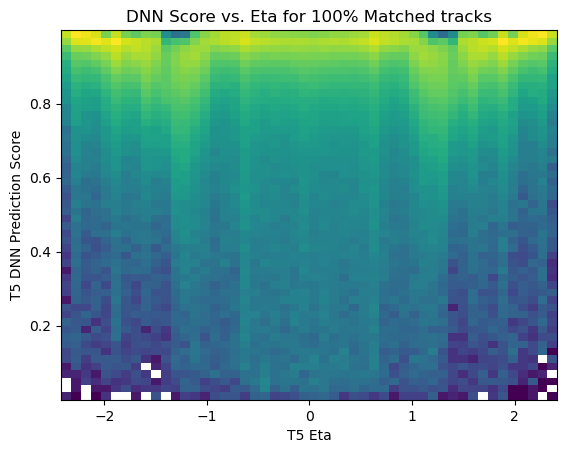

In [8]:
from matplotlib.colors import LogNorm

full_tracks = (np.concatenate(branches['t5_isFake']) == 0) * (np.concatenate(branches['t5_pMatched']) > 0.95)
plt.hist2d(np.concatenate(branches['t5_eta'])[full_tracks], predictions[full_tracks], bins=[50,50], norm=LogNorm())
plt.xlabel("T5 Eta")
plt.ylabel("T5 DNN Prediction Score")
plt.title("DNN Score vs. Eta for 100% Matched tracks")
plt.show()

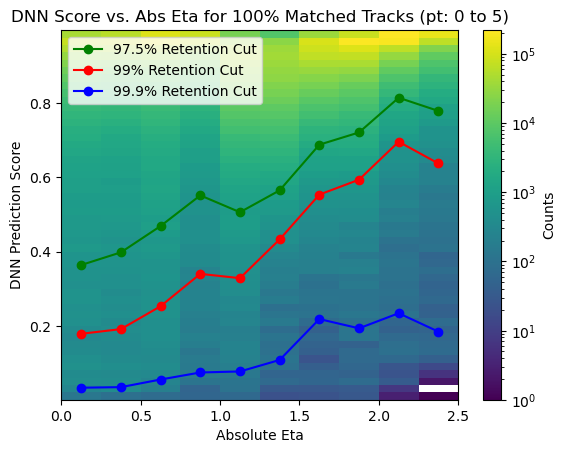

pt: 0 to 5
97.5% Retention Cut: [0.3642 0.3982 0.4692 0.5518 0.5064 0.5653 0.6883 0.7213 0.8149 0.7793]  Mean:  0.5859
99% Retention Cut: [0.1788 0.1914 0.2532 0.3403 0.3287 0.4332 0.5538 0.594  0.6963 0.6378]  Mean:  0.4207
99% Retention Cut: [0.0335 0.035  0.0556 0.0745 0.0773 0.1082 0.2185 0.1935 0.2342 0.1846]  Mean:  0.1215


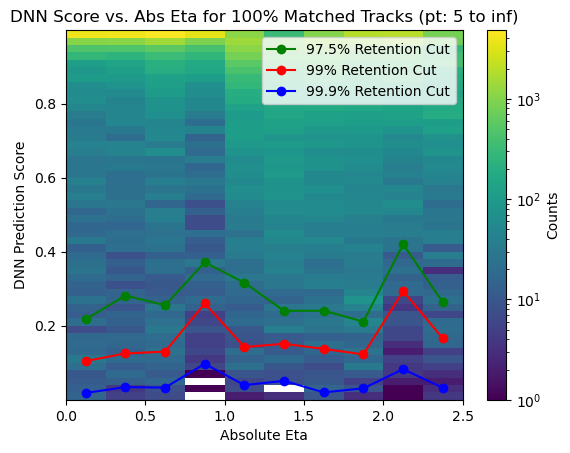

pt: 5 to inf
97.5% Retention Cut: [0.2175 0.2814 0.2554 0.3711 0.3163 0.2402 0.2406 0.2111 0.42   0.2634]  Mean:  0.2817
99% Retention Cut: [0.1045 0.1251 0.1301 0.2601 0.1424 0.1514 0.1374 0.1226 0.2936 0.1656]  Mean:  0.1633
99% Retention Cut: [0.0183 0.0343 0.0329 0.0971 0.0396 0.0511 0.0199 0.031  0.0828 0.0322]  Mean:  0.0439


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Define pt bins and eta bin edges
pt_bins = [0, 5, np.inf]
eta_bin_edges = np.arange(0, 2.75, 0.25)

# Function to calculate cut values and plot for a given pt bin
def plot_for_pt_bin(pt_min, pt_max):
    # Filter data based on pt bin
    abs_eta = np.abs(np.concatenate(branches['t5_eta'])[full_tracks & (np.concatenate(branches['t5_pt']) > pt_min) & (np.concatenate(branches['t5_pt']) <= pt_max)])
    predictions_filtered = predictions[full_tracks & (np.concatenate(branches['t5_pt']) > pt_min) & (np.concatenate(branches['t5_pt']) <= pt_max)]
    
    # Lists to store cut values for different percentiles
    cut_values_96 = []
    cut_values_97 = []
    cut_values_99 = []
    cut_values_99_9 = []
    cut_values_99_5 = []

    # Loop through each eta bin
    for i in range(len(eta_bin_edges) - 1):
        # Get indices of tracks within the current eta bin
        bin_indices = (abs_eta >= eta_bin_edges[i]) & (abs_eta < eta_bin_edges[i + 1])
        
        # Get the corresponding DNN prediction scores
        bin_predictions = predictions_filtered[bin_indices]
        
        # Calculate the percentile cut values for the current bin
        cut_value_96 = np.percentile(bin_predictions, 4)
        cut_value_97 = np.percentile(bin_predictions, 2.5)
        cut_value_99 = np.percentile(bin_predictions, 1)
        cut_value_99_5 = np.percentile(bin_predictions, 0.5)
        cut_value_99_9 = np.percentile(bin_predictions, 0.1)
        
        # Store the cut values
        cut_values_96.append(cut_value_96)
        cut_values_97.append(cut_value_97)
        cut_values_99.append(cut_value_99)
        cut_values_99_9.append(cut_value_99_9)
        cut_values_99_5.append(cut_value_99_5)

    # Plot 2D histogram
    plt.hist2d(abs_eta, predictions_filtered, bins=[eta_bin_edges, 50], norm=LogNorm())
    plt.colorbar(label='Counts')
    plt.xlabel("Absolute Eta")
    plt.ylabel("DNN Prediction Score")
    plt.title(f"DNN Score vs. Abs Eta for 100% Matched Tracks (pt: {pt_min} to {pt_max})")

    # Plot the cut values
    cut_x = eta_bin_edges[:-1] + (eta_bin_edges[1] - eta_bin_edges[0]) / 2  # Mid-points of the bins
    plt.plot(cut_x, cut_values_97, 'g-', marker='o', label='97.5% Retention Cut')
    plt.plot(cut_x, cut_values_99, 'r-', marker='o', label='99% Retention Cut')
    plt.plot(cut_x, cut_values_99_9, 'b-', marker='o', label='99.9% Retention Cut')
    plt.legend()
    
    plt.show()
    
    # Print the cut values
    print(f"pt: {pt_min} to {pt_max}")
    print("97.5% Retention Cut:", np.round(cut_values_97, 4), " Mean: ", np.round(np.mean(cut_values_97),4))
    print("99% Retention Cut:", np.round(cut_values_99, 4), " Mean: ", np.round(np.mean(cut_values_99),4))
    print("99% Retention Cut:", np.round(cut_values_99_9, 4), " Mean: ", np.round(np.mean(cut_values_99_9),4))

# Plot for each pt bin
for i in range(len(pt_bins) - 1):
    plot_for_pt_bin(pt_bins[i], pt_bins[i + 1])
